In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

from matplotlib import rcParams
rcParams['figure.figsize'] = (15, 13)


In [2]:
class pipeline_stage:
    def __init__(self, next_stage=None):
        self.next = next_stage
        
    def invoke_next(self, image):
        if (self.next):
            return self.next(image)
        else:
            return image
        
    def process(self, image):
        return image
    
    def __call__(self, image):
        return self.invoke_next(self.process(image))

def end_of_pipeline(img):
    return img

def to_rgb(image_mask):
    layer = image_mask * 255
    return np.dstack((layer, layer, layer))


In [3]:
def visualize_process_stage(orig_img, processed_img, 
                            orig_title='Original image', 
                            processed_title='Processed Image', 
                            orig_cmap=None,
                            processed_cmap=None,
                            output_file=None):
    fig, axes = plt.subplots(1, 2)

    axes[0].imshow(orig_img, orig_cmap)
    axes[0].set_title(orig_title)

    axes[1].imshow(processed_img, processed_cmap)
    axes[1].set_title(processed_title)

    if (output_file):
        fig.savefig(output_file);


# Camera calibration

In [4]:
from glob import glob

def calibration_images():
    calibration_image_files = glob('camera_cal/calibration*.jpg')
    for fn in calibration_image_files:
        img = mpimg.imread(fn)
        yield cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

def find_chessboard_corners(images):
    board_size = (9, 6)
    obj_corners = np.array([[x, y, 0] for y in range(board_size[1]) for x in range(board_size[0])],
                          dtype=np.float32)

    obj_points = []
    image_points = []
    for img in calibration_images():
        ret, corners = cv2.findChessboardCorners(img, board_size, None)
        if ret: 
            obj_points.append(obj_corners)
            image_points.append(corners)
    
    return (obj_points, image_points)

def calibrate_camera(obj_points, image_points):
    calibration_image_size = (720, 1280)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(
        obj_points, image_points, calibration_image_size, None, None)
        
    if ret: 
        return (mtx, dist)
    else:
        raise "Unable to calibrate camera"

class correct_distortion(pipeline_stage):
    mtx = None
    dist = None
    
    @classmethod
    def calibrate(self, calibration_images):
        obj_points, image_points = find_chessboard_corners(calibration_images)
        mtx, dist = calibrate_camera(obj_points, image_points)
        self.mtx = mtx
        self.dist = dist
    
    def process(self, image):
        return self._undistort_image(image)
    
    def _undistort_image(self, image):
        return cv2.undistort(image, self.mtx, self.dist, None, self.mtx)
    
correct_distortion.calibrate(calibration_images())

# Testing calibration

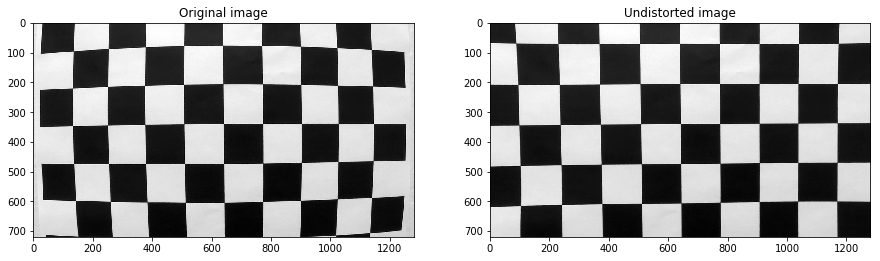

In [5]:
test_image = next(calibration_images())
processor = correct_distortion()
visualize_process_stage(test_image, processor(test_image), 
                        processed_title='Undistorted image',
                        orig_cmap='gray', processed_cmap='gray',
                        output_file='output/calibration_test.png')


# Image processing pipeline

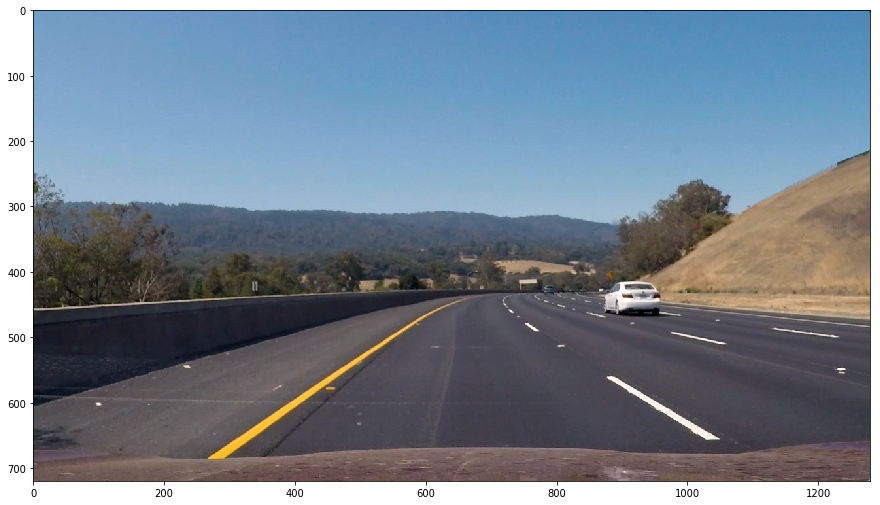

In [6]:
sample_image = mpimg.imread('./test_images/test3.jpg')
plt.imshow(sample_image)

## Correcting distortion

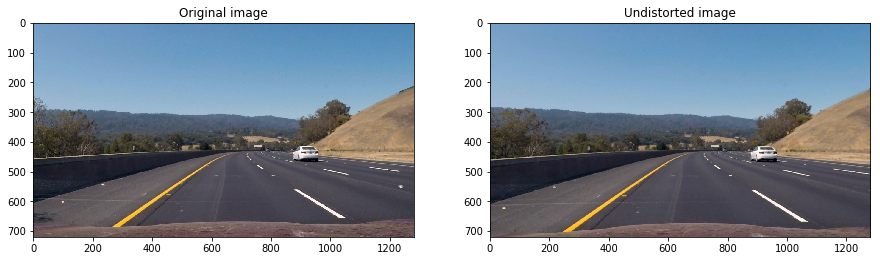

In [7]:
corrector = correct_distortion()
processed_image = corrector(sample_image)

visualize_process_stage(sample_image, processed_image, 
                        processed_title='Undistorted image', 
                        output_file='output/undistorted.png')

## Thresholding

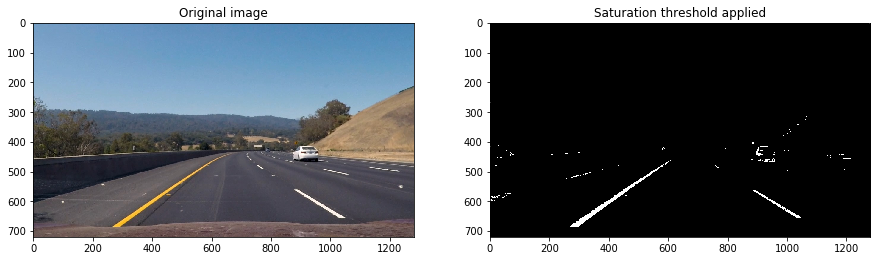

In [8]:
class saturation_threshold(pipeline_stage):
    threshold = (120, 255)
    
    def process(self, image):
        hsl = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        sat = hsl[:, :, 2]
        mask = np.zeros_like(sat)
        mask[(sat > self.threshold[0]) & (sat <= self.threshold[1])] = 1
        return mask
        

thresholder = saturation_threshold()
visualize_process_stage(sample_image, thresholder(sample_image),
                        processed_title='Saturation threshold applied', 
                        processed_cmap='gray',
                        output_file='output/saturation_threshold.png')

## Perspective transform

In [9]:
class perspective_transform(pipeline_stage):
    image_points = np.array([(245, 685), (580, 460), (704, 460), (1053, 667)], dtype=np.float32)
    object_points = np.array([(245, 720), (245, 0), (1053, 0), (1053, 720)], dtype=np.float32)
    perspective_mtx = cv2.getPerspectiveTransform(image_points, object_points)
    
    def process(self, image):
        img_size = (image.shape[1], image.shape[0])
        return cv2.warpPerspective(image, self.perspective_mtx, img_size, flags=cv2.INTER_LINEAR)


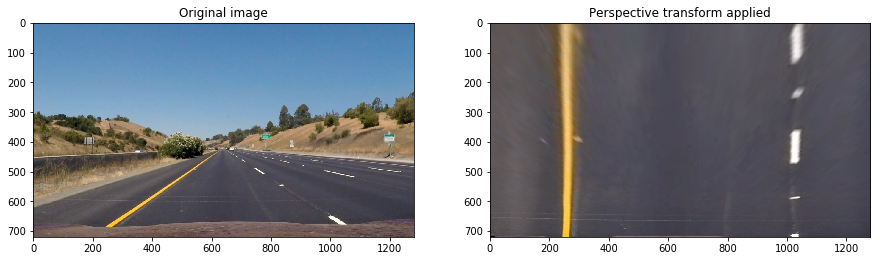

In [10]:
transform = perspective_transform(end_of_pipeline)

sample_image = mpimg.imread('./test_images/straight_lines1.jpg')
warped = transform(sample_image)
visualize_process_stage(sample_image, warped, processed_title='Perspective transform applied', 
                        output_file='output/perspective_transform.png')


# Video processing pipeline

In [11]:
import os.path as path
from moviepy.editor import VideoFileClip
from IPython.display import HTML

def display_video(video_file):
    return HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_file))

def process_video(filename, processor_fn):
    clip = VideoFileClip(filename)
    processed = clip.fl_image(processor_fn)
    
    output_base = path.basename(filename)
    output_file = path.join('output', output_base)
    processed.write_videofile(output_file, audio=False)
    return output_file
    

In [12]:
processor = correct_distortion(saturation_threshold(perspective_transform(to_rgb)))

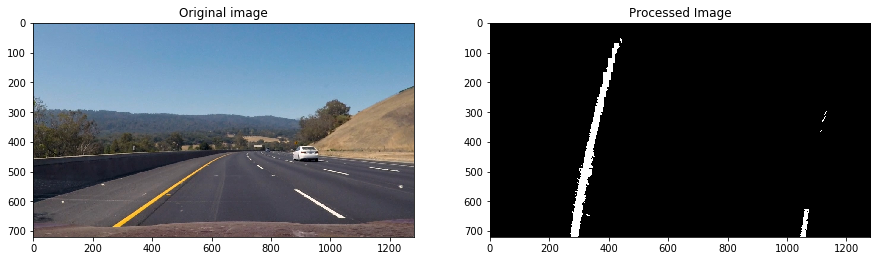

In [13]:
sample_image = plt.imread('./test_images/test3.jpg')
visualize_process_stage(sample_image, processor(processed_image))

In [14]:
input_file = './project_video.mp4'

output = process_video(input_file, processor)
display_video(output)


[MoviePy] >>>> Building video output/project_video.mp4
[MoviePy] Writing video output/project_video.mp4


100%|█████████▉| 1260/1261 [00:58<00:00, 21.42it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output/project_video.mp4 

